#### <ins>Imports/Installs</ins>



##### <ins>Installing required packages (if missing)</ins>

In [336]:
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install xgboost

##### <ins>Import required libs</ins>

In [337]:
import pandas as pd

import matplotlib.pyplot as pyplot

from sklearn import metrics
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

##### <ins>Importing Dataset.csv</ins>

In [338]:
gyro = pd.read_csv('../datasets/gyro_mobile.csv')

##### <ins>Inspecting The Dataset</ins>

In [339]:
def printSummaryStatistics():   # Prints statistical for each column in the dataframe
    gyroCols = gyro.columns.to_list()
    for col in gyroCols:
        print(f"Column: {col} \n{gyro[col].describe()} \nData Type: {gyro[col].dtype}\n")

print(f'{gyro.head()}\n')       # Looking into basic structure
printSummaryStatistics()


       accX      accY      accZ     gyroX     gyroY     gyroZ timestamp  \
0 -0.496517  3.785628  8.954828 -0.142849 -0.126159 -0.022539   34:22.9   
1 -0.462388  3.869603  9.281898  0.084349  0.096695  0.092130   34:23.0   
2 -0.296084  3.820505  8.930728  0.061763  0.051543  0.071287   34:23.1   
3 -0.469723  3.890110  8.744067  0.007641  0.028679  0.109433   34:23.2   
4 -0.472418  4.109105  8.941207 -0.123640  0.099057  0.051943   34:23.3   

   Activity  
0         1  
1         1  
2         1  
3         1  
4         1  

Column: accX 
count    31991.000000
mean         0.023825
std          0.741396
min         -3.673361
25%         -0.472193
50%         -0.024998
75%          0.477208
max          4.678671
Name: accX, dtype: float64 
Data Type: float64

Column: accY 
count    31991.000000
mean         2.153858
std          1.085466
min         -4.386029
25%          1.413062
50%          2.119143
75%          2.928435
max          6.377039
Name: accY, dtype: float64 
Data Typ

Insights:
- 31991 data points
- Every feature is continuous
- Activity is either 1 or 0 (binary classification)
- Dataset contains a timestamp that might be dropped

#### <ins>Data Preprocessing and Training</ins>

##### <ins>Dropping timestamp and splitting data into training and testing</ins>

In [340]:
gyro = gyro.drop(columns='timestamp')

xtrain, xtest, ytrain, ytest = train_test_split(
    gyro.iloc[:,:6],
    gyro.iloc[:,6:],
    test_size=0.2,
    random_state=0
)

##### <ins>Training and Improving</ins><br>
Um eine gute Anzahl an Estimators zu bestimmen, wird zuerst ein Modell mithilfe von Early Stopping, sowie einer großen Menge an Estimatoren trainiert. Hiermit wird die beste Anzahl an Iterationen ermittelt und mit dieser Anzahl ein weiteres Modell trainiert.

In [341]:
preModel = XGBClassifier(           # "Spendermodell"
    objective='binary:logistic',
    n_estimators=10000,             # "Große Anzahl an Schaetzern, die nicht erreicht werden soll"
    early_stopping_rounds=20,      # Anzahl an Runden, bei denen sich das Modell nicht verbessern muss, bis abgebrochen wird
    max_depth=2,
    learning_rate=0.1
)

evaldata=[(xtrain,ytrain),(xtest,ytest)]          # Datensatz zur Evaluierung

preModel.fit(xtrain, ytrain, eval_set=evaldata, verbose=False)

bIter = preModel.best_iteration     # Beste Anzahl an Estimatoren

model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=bIter,
    # tree_method = 'exact', # tree_method hist can cause problems with m2cgen
    max_depth=2,
    learning_rate=0.1,
    base_score=0.5
)

model.fit(xtrain, ytrain, eval_set=evaldata, verbose=False)

yhat = model.predict(xtest)

#### <ins>Func Definitions</ins>

##### <ins>Performance Metrics and Evaluation</ins>

In [342]:
def printConfusionMatrix(): # Confusion Matrix
    metrics.ConfusionMatrixDisplay.from_estimator(model, xtest, ytest, cmap='Blues')
    pyplot.show()

def plotLossCurves():       # Loss Curves
    # save evaluation results
    results = model.evals_result()
    # plot curves
    pyplot.plot(results['validation_0']['logloss'], label='train')
    pyplot.plot(results['validation_1']['logloss'], label='train')
    # show the legend
    pyplot.xlabel('Iterations')
    pyplot.ylabel('Log Loss')
    pyplot.legend()
    # show the plot
    pyplot.show()

def printClassReport(): # Classification Report
    # Report
    print(metrics.classification_report(ytest, yhat, digits = 3))

def printMisc():
    # Misc
    print(f'# Trees: \t{bIter}')
    print(f'Test Accuracy: \t{accuracy_score(ytest, yhat)}')
    print(f'Base_Score{model.base_score}')
    print(f'Best Iteration: {bIter}')
    print(f'\nPredict_Proba Return: \n{model.predict_proba(xtest)}')

##### <ins>Porting this Bitch</ins>

In [343]:
def portToC(model):
    import m2cgen as m2c

    model.base_score = 0

    with open('../exported_models/currentExport.c','w') as f:
        code = m2c.export_to_c(model)
        f.write(code)

portToC(model)
        

##### <ins>Generating Code for Lazy People</ins>

In [344]:
def genFloat(start=0, size=500, time=100):
    start = start
    size = size
    time = time
    length = 2
    

    print(f'void infer() {{')
    print(f'\t// Printing Range:')
    print(f'\tSerial.println(\"Start: {start} | End: {start+size}\");\n')
    print(f'\tSerial.println("aScore0,aScore1");')

    print(f'\t// Declarations:')
    print(f'\tint length = {length};')
    print(f'\tfloat result[length];')
    print(f'\tint time = {time};\n')

    print(f'\t// Model Inference')
    for x in range(start,(start+size)):  
        print(f'\tfloat x_{x}[] = {{' , end="")    
        features = xtest.values[x]
        for i in range(len(features)):
            if i < (len(features)-1):
                print(features[i], end=", ")
            else:
                print(features[i], end="};\n")
        print(f'\tint y_{x} = {yhat[x]};')
        print(f'\tscore(x_{x}, result);')
        # print(f'\tprintScoreCompare(result, length, y_{x});')
        print(f'\tprintScoreCompareCSV(result, length, y_{x});')
        print(f'\tdelay(time);\n')
    print(f'}}')

def genDouble(start=0, size=500, time=100):
    start = start
    size = size
    time = time
    length = 2

    print(f'void infer() {{')
    print(f'\t// Printing Range:')
    print(f'\tSerial.println(\"Start: {start} | End: {start+size}\");\n')
    print(f'\tSerial.println("aScore0,aScore1");')
    print(f'\t// Declarations:')
    print(f'\tint length = {length};')
    print(f'\tdouble result[length];')
    print(f'\tint time = {time};\n')

    print(f'\t// Model Inference')
    for x in range(start,(start+size)):
        print(f'\tdouble x_{x}[] = {{' , end="")        
        features = xtest.values[x]
        for i in range(len(features)):
            if i < (len(features)-1):
                print(features[i], end=", ")
            else:
                print(features[i], end="};\n")
        print(f'\tint y_{x} = {yhat[x]};')
        print(f'\tscore(x_{x}, result);')
        # print(f'\tprintScoreCompare(result, length, y_{x});')
        print(f'\tprintScoreCompareCSV(result, length, y_{x});')
        print(f'\tdelay(time);\n')
    print(f'}}')

##### <ins>Generating Inference Data</ins>

In [345]:
def generateProbDF(localCapture=model,features_test=xtest):
    xtestlist = localCapture.predict_proba(features_test).tolist()
    list1 = []
    list2 = []

    for x in xtestlist:
        list1.append(round(x[0],4))
        list2.append(round(x[1],4))

    probDF = pd.DataFrame({
        'Label': localCapture.predict(features_test),
        'Prob0': list1,
        'Prob1': list2
    })
    return(probDF)

def importInoCapture():
    serial = pd.read_csv('../datasets/inoCapture.csv')
    serial = serial.truncate(after=(len(serial)-2)) # get rid of ##### REPEATING... #####
    return(serial)

def generateComparison(probDF=generateProbDF(),inoCapture=importInoCapture()):
    probDF = probDF.truncate(after=(len(inoCapture)-1))
    probDF = probDF.join(inoCapture)
    probDF.to_csv('../datasets/compared-gyro-float.csv')

#### <ins>Main</ins>

##### <ins>Evaluation Metrics</ins>

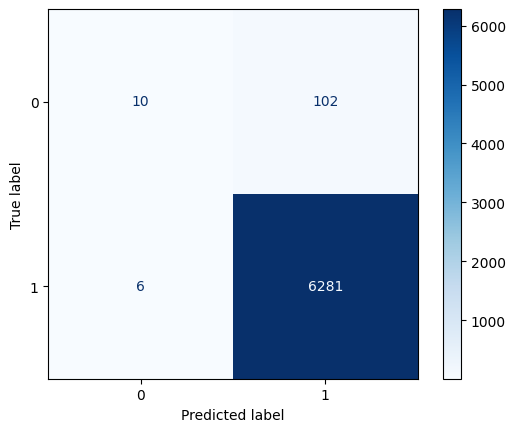

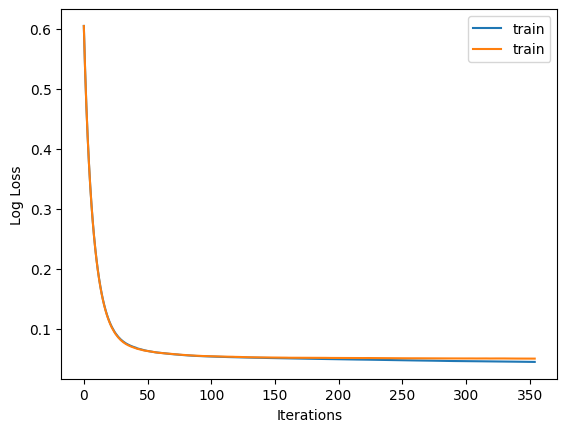

              precision    recall  f1-score   support

           0      0.625     0.089     0.156       112
           1      0.984     0.999     0.991      6287

    accuracy                          0.983      6399
   macro avg      0.805     0.544     0.574      6399
weighted avg      0.978     0.983     0.977      6399

# Trees: 	355
Test Accuracy: 	0.9831223628691983
Base_Score0
Best Iteration: 355

Predict_Proba Return: 
[[9.1433525e-05 9.9990857e-01]
 [3.0517578e-05 9.9996948e-01]
 [4.5132995e-02 9.5486701e-01]
 ...
 [3.0398369e-05 9.9996960e-01]
 [2.1252632e-03 9.9787474e-01]
 [2.3561716e-04 9.9976438e-01]]


In [346]:
printConfusionMatrix()
plotLossCurves()
printClassReport()
printMisc()

##### <ins>Code Generation</ins>

In [347]:
# genFloat()

genDouble(size=250)

void infer() {
	// Printing Range:
	Serial.println("Start: 0 | End: 250");

	Serial.println("aScore0,aScore1");
	// Declarations:
	int length = 2;
	double result[length];
	int time = 100;

	// Model Inference
	double x_0[] = {-0.623154, 3.131787, 11.257041, -0.736, -0.059642, 0.56997};
	int y_0 = 1;
	score(x_0, result);
	printScoreCompareCSV(result, length, y_0);
	delay(time);

	double x_1[] = {1.366808, 2.376458, 11.491304, -0.219388, 0.297717, -0.341959};
	int y_1 = 1;
	score(x_1, result);
	printScoreCompareCSV(result, length, y_1);
	delay(time);

	double x_2[] = {-0.931214, 1.462459, 9.501641, 0.435188, 0.209586, 0.465394};
	int y_2 = 1;
	score(x_2, result);
	printScoreCompareCSV(result, length, y_2);
	delay(time);

	double x_3[] = {0.209265, 2.590363, 12.200529, 0.147434, -0.108728, -0.057775};
	int y_3 = 1;
	score(x_3, result);
	printScoreCompareCSV(result, length, y_3);
	delay(time);

	double x_4[] = {-0.111518, 1.748065, 8.976833, 0.754365, 0.03308, -0.407495};
	int y_4 = 1;
	sc

##### <ins>Generate C-Port</ins>

In [348]:
portToC(model)

##### <ins>Generate Inference Data and Comparison</ins>

In [349]:
# generateProbDF()
# importInoCapture()

generateComparison()